<h1>IBM Capstone Project Week 3 Assignment</h1>

<h2>Question 1</h2>

In [37]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url, 'lxml')
wiki_table = soup.find('table',{'class':'wikitable sortable'})
rows = wiki_table.find_all('tr')

In [3]:
PostalCode = []
Borough = []
Neighbourhood = []

for row in rows:
    try:
        PostalCode.append(row.find("td").text)
        Borough.append(row.find("td").find_next("td").text)
        Neighbourhood.append(row.find("td").find_next("td").find_next("td").text)
    except:
            pass

df = pd.DataFrame()
df['PostalCode'] = PostalCode
df['Borough'] = Borough
df['Neighbourhood'] = Neighbourhood
df['Neighbourhood'].replace({r'\n':''}, inplace=True, regex=True)

df = df.drop(df.loc[df['Borough']=='Not assigned'].index)

for row in df.iterrows():
    if df.loc[row[0], 'Neighbourhood'] == 'Not assigned':
        df.loc[row[0], 'Neighbourhood'] = df.loc[row[0], 'Borough']

df = df.groupby(['PostalCode','Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x)).reset_index().sort_values(by=['PostalCode'], ascending=True)

In [4]:
df.shape

(103, 3)

In [5]:
df

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


<h2>Question 2</h2>

In [6]:
df2 = pd.read_csv('./Geospatial_Coordinates.csv')
df2.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
df2.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
df = df.merge(df2, how='inner', on='PostalCode')
df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [8]:
print(df.shape)

(103, 5)


<h2>Question 3</h2>

In [26]:
map_toronto = folium.Map(location=[43.71, -79.38], zoom_start=11)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [63]:
k_means = KMeans(init="k-means++", n_clusters=6, n_init=12)
X = df.loc[:,['Latitude', 'Longitude']].as_matrix()
k_means.fit(X)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [64]:
k_means_labels = k_means.labels_
k_means_labels
df['District'] = k_means_labels
df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,District
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,2
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,2
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,2
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2


In [65]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 43.64660942, -79.51571835],
       [ 43.6625929 , -79.38321178],
       [ 43.78769261, -79.22129714],
       [ 43.73913951, -79.41656081],
       [ 43.72881042, -79.30633166],
       [ 43.72751776, -79.53223569]])

In [66]:
colors = {0:'orange', 1:'red', 2:'blue', 3:'green', 4:'purple', 5:'pink'}

for lat, lng, borough, neighborhood, district in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood'], df['District']):
    label = 'District {}: {}, {}'.format(district, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[district],
        fill=True,
        fill_color=colors[district],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Map of Toronto divided into 6 districts using K-means model

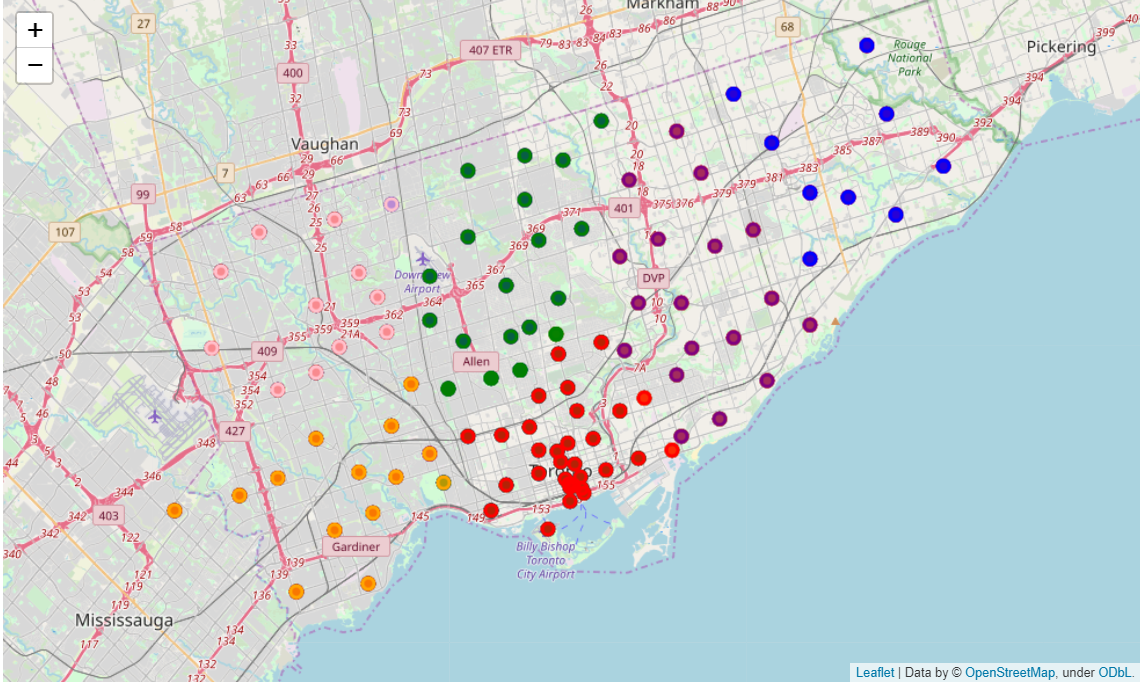

In [77]:
from PIL import Image
image = Image.open('./map_toronto.png')
image